# **Data Preprocess**

## Importation & Data loading

Preparing necessary packages (may need to add more):

In [108]:
import numpy as np  # Work with multi-dimenional data
import pandas as pd # Work with relational data
import matplotlib.pyplot as plt # Visualize data
import seaborn as sns # Visualize data base on matplotlib
import nltk #
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from scipy import sparse

nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load data from files

In [109]:
directory = 'data/dataset/raw/'

# This method use to extract all the file in the input list
def extract_data(files):
  data_x_raw = list()
  data_y_raw = list()
  for file in files:
    with open(directory + file) as f:
      for line in f:
        line = line.strip('\n')
        x_raw, y_raw = line.split(sep=';')

        data_x_raw.append(x_raw)
        data_y_raw.append(y_raw)

  return data_x_raw, data_y_raw

In [110]:
# Get all data

X_raw, y_raw = extract_data(['train.txt', 'val.txt', 'test.txt'])
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.2)

print("Traning data's size is:", len(X_train_raw))
print("Test data's size is:", len(X_test_raw))

Traning data's size is: 16000
Test data's size is: 4000


## Inital feature Extraction


Removing the stopword

In [111]:
file = open("data/stopwords/stop_words_english.txt", 'r', encoding='utf-8')
stopword_list = file.read().split('\n')
file.close()
print(len(stopword_list))

850


Vectorize the data:

1.   Bag Of Words model (https://en.wikipedia.org/wiki/Bag-of-words_model)
2.   BoW/TF-IDF model (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)



In [112]:
# Scikit CountVectorizer:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

count_vector = CountVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
count_vector.fit(X_train_raw + X_test_raw)
X_train_bow = count_vector.transform(X_train_raw)
X_test_bow = count_vector.transform(X_test_raw)
dictionary = count_vector.get_feature_names_out()

print("Shape of preprocessed training data X using BoW model is: ", X_train_bow.shape)

Shape of preprocessed training data X using BoW model is:  (16000, 100817)


In [113]:
# Scikit TF-IDF:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

tfidf_vector = TfidfVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw + X_test_raw)
X_train_tfidf = tfidf_vector.transform(X_train_raw)
X_test_tfidf = tfidf_vector.transform(X_test_raw)

print("Shape of preprocessed training data X using BoW/TF-IDF model is: ", X_train_tfidf.shape)

Shape of preprocessed training data X using BoW/TF-IDF model is:  (16000, 100817)


Cast output list to ndarray

In [114]:
y_train = np.asarray(y_train_raw)
y_test = np.asarray(y_test_raw)

*Luckily we're quite done with the abbreviations!*

## Initial exploratory Data Analysis (EDA)

Average length of the comment:

In [115]:
# Calculate average number of characters
sum_of_chars = sum([len(x) for x in X_train_raw])
mean_number_chars = sum_of_chars / len(X_train_raw)

# Calculate average number of words
sum_of_words = sum([len(x.split()) for x in X_train_raw])
mean_number_words = sum_of_words / len(X_train_raw)

# Print
print('The mean number of characters of each line is: %d' % mean_number_chars)
print('The mean number of words of each line is: %d' % mean_number_words)

The mean number of characters of each line is: 96
The mean number of words of each line is: 19


Statistic of output labels:

Number of labels is: 6
Labels: anger, fear, joy, love, sadness, surprise

----------------------------------------------------------------------------



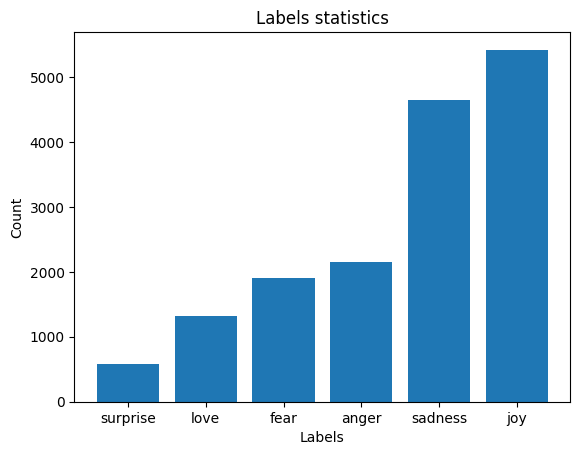

In [116]:
# Number of labels:
labels = np.unique(y_train)
print('Number of labels is: %d' % len(labels))
print('Labels: ' + ', '.join(labels))
print('\n----------------------------------------------------------------------------\n')

# Plot:
df = pd.DataFrame(
  dict(
    labels = labels,
    label_elements_count = [y_train_raw.count(label) for label in labels]
  )
)
df = df.sort_values('label_elements_count')

plt.title(label='Labels statistics')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.bar('labels', 'label_elements_count', data=df)

plt.show()

Statistics of words with the highest frequency of each label:

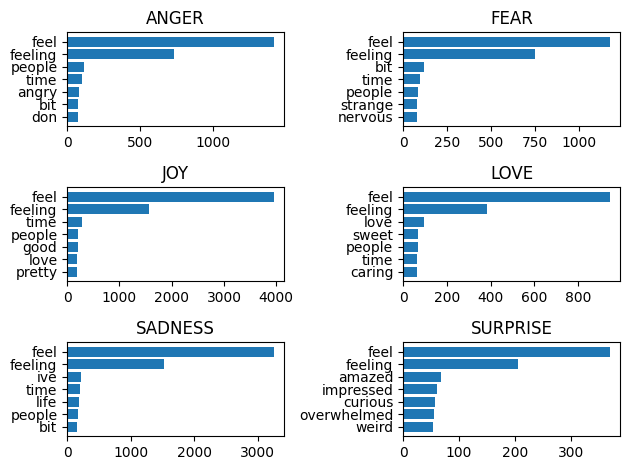

In [117]:
def show_highest_frequency_words(dataset):
  vect_arr = dataset.toarray()
  vect_aggr = np.zeros(shape=(len(labels), vect_arr.shape[1]))

  for idx in range(len(vect_arr)):
    label_idx = int(np.where(labels==y_train[idx])[0][0])

    vect_aggr[label_idx] += vect_arr[idx]

  fig, axs = plt.subplots(3, 2)

  for label_idx in range(len(labels)):
    axs_x, axs_y = label_idx // 2, label_idx % 2

    plt_ref = axs[axs_x][axs_y]
    plt_ref.set_title(labels[label_idx].upper())

    x_axis, y_axis = list(), list()
    n_argmax = np.argpartition(vect_aggr[label_idx], -7)[-7:]
    n_argmax = n_argmax[np.argsort(vect_aggr[label_idx][n_argmax])]
    for i in n_argmax:
      x_axis.append(dictionary[i])
      y_axis.append(vect_aggr[label_idx][i])

    x_axis = np.asarray(x_axis)
    y_axis = np.asarray(y_axis)

    plt_ref.barh(x_axis, y_axis)

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

show_highest_frequency_words(X_train_bow)

## Data Fixing

This part will eliminate all the words that have bad influence to our data.
All the words will be stored in a file stored in file *filtered_words.txt*

* Words appears so many times but don't contribute much (*feel*, *feeling*,...).
* Words have no mean (*aa*,*ab*,...)
* Words appears only a few

In [133]:
file = open("data/stopwords/stop_words_english.txt", 'r', encoding='utf-8')
stop_words = file.read().split('\n')

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
tmp = stopwords.words('english')

unfiltered_stopwords = stop_words + tmp

print(len(unfiltered_stopwords))

1029


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create tokenize function with the help of nltk packages

In [134]:
stemmer = PorterStemmer()

def unfiltered_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in unfiltered_stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

Fit the data again

In [135]:
# Dictionary semi_filtered: Using basic stopwords only

count_vector = CountVectorizer(stop_words=unfiltered_stopwords, tokenizer=unfiltered_tokenize, ngram_range=(1, 2))
count_vector.fit(X_train_raw + X_test_raw)
X_train_bow_semi_filtered = count_vector.transform(X_train_raw)
X_test_bow_semi_filtered = count_vector.transform(X_test_raw)
dictionary_semi_filtered = count_vector.get_feature_names_out()

tfidf_vector = TfidfVectorizer(stop_words=unfiltered_stopwords, tokenizer=unfiltered_tokenize, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw + X_test_raw)
X_train_tfidf_semi_filtered = tfidf_vector.transform(X_train_raw)
X_test_tfidf_semi_filtered = tfidf_vector.transform(X_test_raw)

In [136]:
# Dictionary semi_mono: Using basic filters, containing only 1-gram, used to perform LASSO-filter to obtain L1 dict

count_vector = CountVectorizer(stop_words=unfiltered_stopwords, tokenizer=unfiltered_tokenize, ngram_range=(1, 1))
count_vector.fit(X_train_raw + X_test_raw)
X_train_bow_semi_mono = count_vector.transform(X_train_raw)
X_test_bow_semi_mono = count_vector.transform(X_test_raw)
dictionary_semi_mono = count_vector.get_feature_names_out()

Sorting out the useless stopwords to make L1 dictionary. We perform LASSO Logistic Regression on dictionary_semi_mono to sort out all useless stopwords (criterion: L2 norm of the L1 weight = 0), then make it a new stopword list.

In [137]:
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack
linear_semi_mono = LogisticRegression(penalty='l1', solver='saga', random_state = 42)
linear_semi_mono.fit(vstack((X_train_bow_semi_mono, X_test_bow_semi_mono)), 
                     np.concatenate((y_train.reshape(16000, 1), y_test.reshape(4000, 1))))

LogisticRegression(penalty='l1', random_state=42, solver='saga')

In [138]:
print(X_train_bow_semi_mono.shape)

(16000, 11182)


In [139]:
print(linear_semi_mono.coef_.shape)
lin_coef = linear_semi_mono.coef_.T

(6, 11182)


In [140]:
useless_coef = list()
for i in range(lin_coef.shape[0]):
    if (lin_coef[i] == np.zeros((lin_coef.shape[1]))).all():
        useless_coef.append(i)

In [141]:
print(len(useless_coef))

9593


In [142]:
with open("data/stopwords/useless.txt", 'w') as file:
    for i in useless_coef:
        file.write(dictionary_semi_mono[i])
        file.write('\n')

In [143]:
file = open("data/stopwords/useless.txt", 'r', encoding='utf-8')
useless = file.read().split('\n')

L1_stopwords = unfiltered_stopwords + useless


In [144]:
def useless_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in L1_stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

# Dictionary L1: Obtained by selecting useful tokens from semi_mono using L1 decomposition.

count_vector = CountVectorizer(stop_words=L1_stopwords, tokenizer=useless_tokenize, ngram_range=(1, 2))
count_vector.fit(X_train_raw + X_test_raw)
X_train_bow_L1 = count_vector.transform(X_train_raw)
X_test_bow_L1 = count_vector.transform(X_test_raw)
dictionary_L1 = count_vector.get_feature_names_out()

tfidf_vector = TfidfVectorizer(stop_words=L1_stopwords, tokenizer=useless_tokenize, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw + X_test_raw)
X_train_tfidf_L1 = tfidf_vector.transform(X_train_raw)
X_test_tfidf_L1 = tfidf_vector.transform(X_test_raw)

In [145]:
print("The length of the semi-filtered dictionary: ", len(dictionary_semi_filtered))
print("The length of the L1 dictionary: ", len(dictionary_L1))

The length of the semi-filtered dictionary:  86216
The length of the L1 dictionary:  46002


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train_bow_semi_filtered, y_train)
y_pred = model.predict(X_test_bow_semi_filtered)
print(accuracy_score(y_pred, y_test))

0.878


## Export data to files

Dataset input: $X\_type\_algo\_filter$
- [type]: Dataset is train/test set.
- [algo]: Dataset is tokenized using which algorithm. "bow" stands for Bag of Words, while "tfidf" stands for TF-IDF
- [filter]: Dataset is tokenized using which filter. If "L1" appears, the dataset is tokenized using L1-trimmed filter. Otherwise, it is tokenized using basic filter.

Dataset output: $Y\_type$ 
- [type]: Dataset is train/test set.

In [152]:
save_directory = "data/dataset/processed/"

sparse.save_npz(save_directory + "X_train_bow.npz", X_train_bow_semi_filtered)
sparse.save_npz(save_directory + "X_test_bow.npz", X_test_bow_semi_filtered)

sparse.save_npz(save_directory + "X_train_tfidf.npz", X_train_tfidf_semi_filtered)
sparse.save_npz(save_directory + "X_test_tfidf.npz", X_test_tfidf_semi_filtered)

sparse.save_npz(save_directory + "X_train_bow_L1.npz", X_train_bow_L1)
sparse.save_npz(save_directory + "X_test_bow_L1.npz", X_test_bow_L1)

sparse.save_npz(save_directory + "X_train_tfidf_L1.npz", X_train_tfidf_L1)
sparse.save_npz(save_directory + "X_test_tfidf_L1.npz", X_test_tfidf_L1)

np.savetxt(save_directory + "y_train.txt", y_train, fmt='%s')
np.savetxt(save_directory + "y_test.txt", y_test, fmt='%s')

## Variables summary




---


**X_train_raw**, **y_train_raw**: ***list***

Raw training data which is extracted directly from files.

---


**X_test**, **y_test**: ***list***

  Raw testing data which is extracted directly from files.

---


**stopword_list**: ***list***

 List of stop words used in BoW and BoW/TF-IDF models

---


**dictionary**: ***numpy.ndarray***

 Dictionary of words which is used to vectorized the data and number of occurences.

---


**X_train_bow_(suf)**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW model.

---


**X_train_tfidf_(suf)**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW/TFIDF model

---


**X_test_bow_(suf)**: ***scipy.sparse._csr.csr_matrix***

 Testing data input which is vectorized by the BoW model.

---


**X_test_tfidf_(suf)**: ***scipy.sparse._csr.csr_matrix***

 Testing data input which is vectorized by the BoW/TFIDF model

---


**y_train**: ***numpy.ndarray***

 Preprocessed traning data output


---

**(suf)**:

This depends on which stopword set is used to tokenize the datasets. Currently, we offer 2 choices:
- (suf) == "semi_filtered": Basic stopword set, imported from NLTK as well as the Internet source referred above
- (suf) == "L1": Augmented stopword set, with addition of "useless" tokens identified by performing a LASSO scan on "semi_filtered" set with only 1-gram allowed.